In [1]:
import source.preprocess as prep
from source.model import *
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import torch
import torch.nn as nn

In [3]:
# path to collect the sequence data    
main_path = 'training_data'    
SH3_path = main_path + '/sh3_59.fasta'

# read relative enrichment score
SH3_RE = np.load('training_data/RE.npz')['RE_mapping']

# read the sequence data
SH3_sequences = prep.get_seq(SH3_path)

# clean up data
sample, positions = len(SH3_sequences), len(SH3_sequences[0])
SH3_MSA = prep.create_MSA(SH3_sequences, sample, positions)

# pandas dataframe format
SH3_df = pd.DataFrame(SH3_MSA)
SH3_df.columns = ['Sequence']

SH3_onehot_inputs = prep.create_one_hot(SH3_df)

# hyperparameters ...

z_dim, alpha = 3, 0.1
samples, seq_len, aa_var = SH3_onehot_inputs.shape
input_dim = seq_len*aa_var # flatten input tensor
intermediate_dim = input_dim # scalar * intermediate_dim = hidden NN width

## Load pretrained weights (model used for the experiments):

In [4]:
model = MMD_VAE(zdims = 3, seq_len=seq_len, aa_var=aa_var, alpha = alpha)
model.load_state_dict(torch.load('source/VAE_SH3.pyt',map_location='cpu'))
model.eval()

MMD_VAE(
  (encoder): Encoder(
    (model): Sequential(
      (0): Linear(in_features=1239, out_features=1858, bias=True)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=1858, out_features=1858, bias=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=True)
      (5): BatchNorm1d(1858, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Linear(in_features=1858, out_features=1858, bias=True)
      (7): LeakyReLU(negative_slope=0.1, inplace=True)
      (8): Linear(in_features=1858, out_features=3, bias=True)
    )
  )
  (decoder): Decoder(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=1858, bias=True)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
      (2): BatchNorm1d(1858, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=1858, out_features=1858, bias=True)
      (4): LeakyReLU(negative_slope=0.1, inplace=T

In [5]:
# Latent variable of the whole dataset (5299 sequences)
nat_z = model.encoder(torch.FloatTensor(SH3_onehot_inputs)).detach().numpy()

# Latent variable of functional sequeneces
func_z = nat_z[SH3_RE > -1.5] # arbitrary treshold

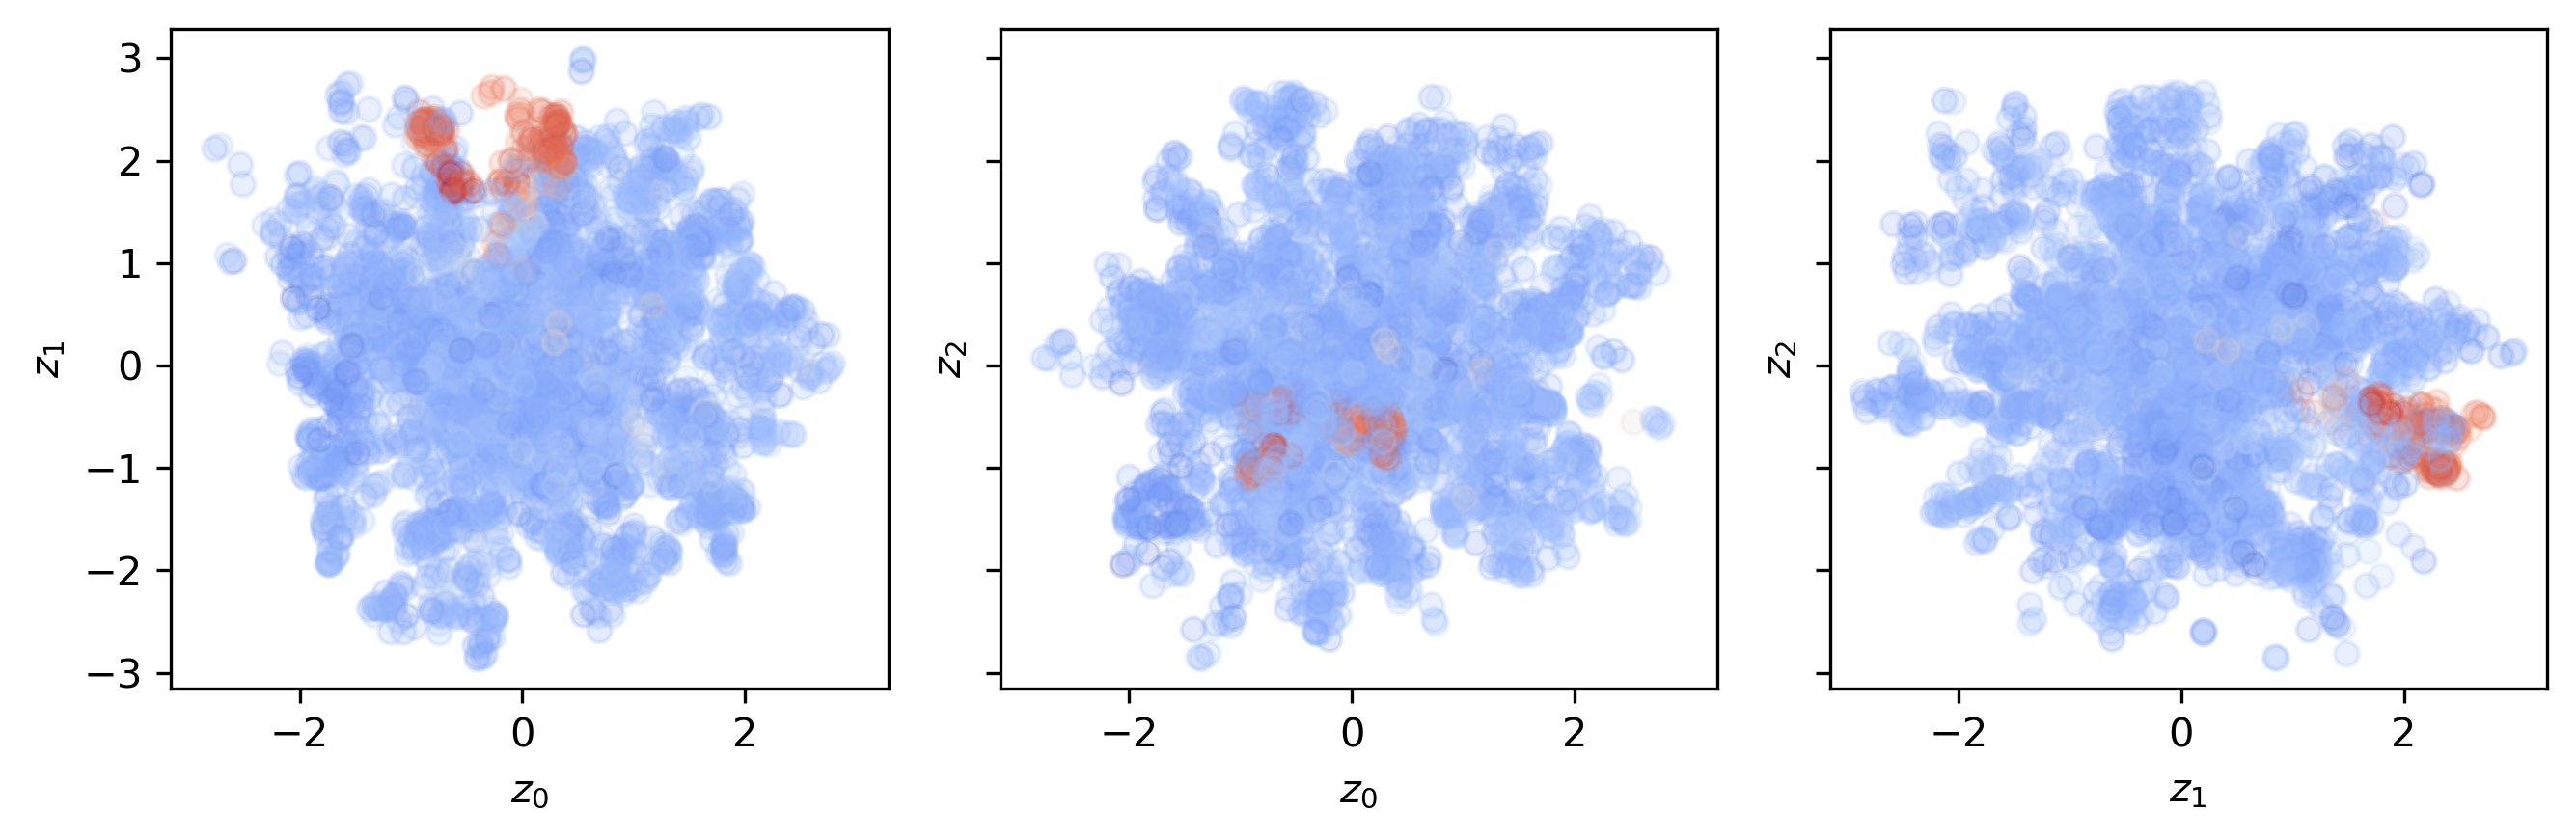

In [6]:
fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 300, sharex= True, sharey = True )
transparency = .2

axes[0].scatter(nat_z[:,0],nat_z[:,1],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)
axes[1].scatter(nat_z[:,0],nat_z[:,2],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)
axes[2].scatter(nat_z[:,1],nat_z[:,2],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plt.tight_layout()


## Global sampling

In [7]:
n_gen = 2000

np.random.seed(999)
global_z = np.random.normal(0., 1., (n_gen, z_dim))
global_samples = model.decoder(torch.FloatTensor(global_z))
global_samples = torch.argmax(global_samples, axis = 2)
global_samples = global_samples.detach().numpy()

In [8]:
global_aa = prep.int2aa(global_samples)

functional = []

for num, i in enumerate(global_aa):
    
    motif = i[34:38]
    
    # motif of potentially funcional Sho1
    if 'RWW' in motif or 'KWW' in motif or 'KWF' in motif or 'RWF' in motif or 'RWY' in motif or 'KWY' in motif:
        if i[46:53] in ['GIAPSNY','GICPSNY','GIIPSNY','GIVPSNY','GILPSNY','GMAPSNF','GQVPSNF',
                        'GIMPSNY','GVVPSNY','GVIPSNY','GIAPSNF','GLIPSNY','GAAPSNY','GFIPSNY'] and \
        i[11] in 'YFWRCS' and i[18] in 'E' and i[32] not in 'DE' and i[5] in 'GACSTVIEN' and i[41]!='V':
            functional.append(num)

print(len(functional))

42


## Local sampling

In [9]:
n_gen = 1000

np.random.seed(999)
local_z = np.random.normal(np.mean(func_z, axis = 0), np.std(func_z, axis = 0), (n_gen, z_dim))
local_samples = model.decoder(torch.FloatTensor(local_z))
local_samples = torch.argmax(local_samples, axis = 2)
local_samples = local_samples.detach().numpy()

In [10]:
local_aa = prep.int2aa(local_samples)

functional = []

for num, i in enumerate(local_aa):
    
    motif = i[34:38]
    
    # motif of potentially funcional Sho1
    if 'RWW' in motif or 'KWW' in motif or 'KWF' in motif or 'RWF' in motif or 'RWY' in motif or 'KWY' in motif:
        if i[46:53] in ['GIAPSNY','GICPSNY','GIIPSNY','GIVPSNY','GILPSNY','GMAPSNF','GQVPSNF',
                        'GIMPSNY','GVVPSNY','GVIPSNY','GIAPSNF','GLIPSNY','GAAPSNY','GFIPSNY'] and \
        i[11] in 'YFWRCS' and i[18] in 'E' and i[32] not in 'DE' and i[5] in 'GACSTVIEN' and i[41]!='V':
            functional.append(num)

print(len(functional))

831


## Scatter plot sampled squences

In [11]:
global_df = pd.DataFrame(global_aa)
global_df.columns = ['Sequence']

local_df = pd.DataFrame(local_aa)
local_df.columns = ['Sequence']

global_onehot_inputs = prep.create_one_hot(global_df)
local_onehot_inputs = prep.create_one_hot(local_df)

global_z_reembed = model.encoder(torch.FloatTensor(global_onehot_inputs)).detach().numpy()
local_z_reembed = model.encoder(torch.FloatTensor(local_onehot_inputs)).detach().numpy()

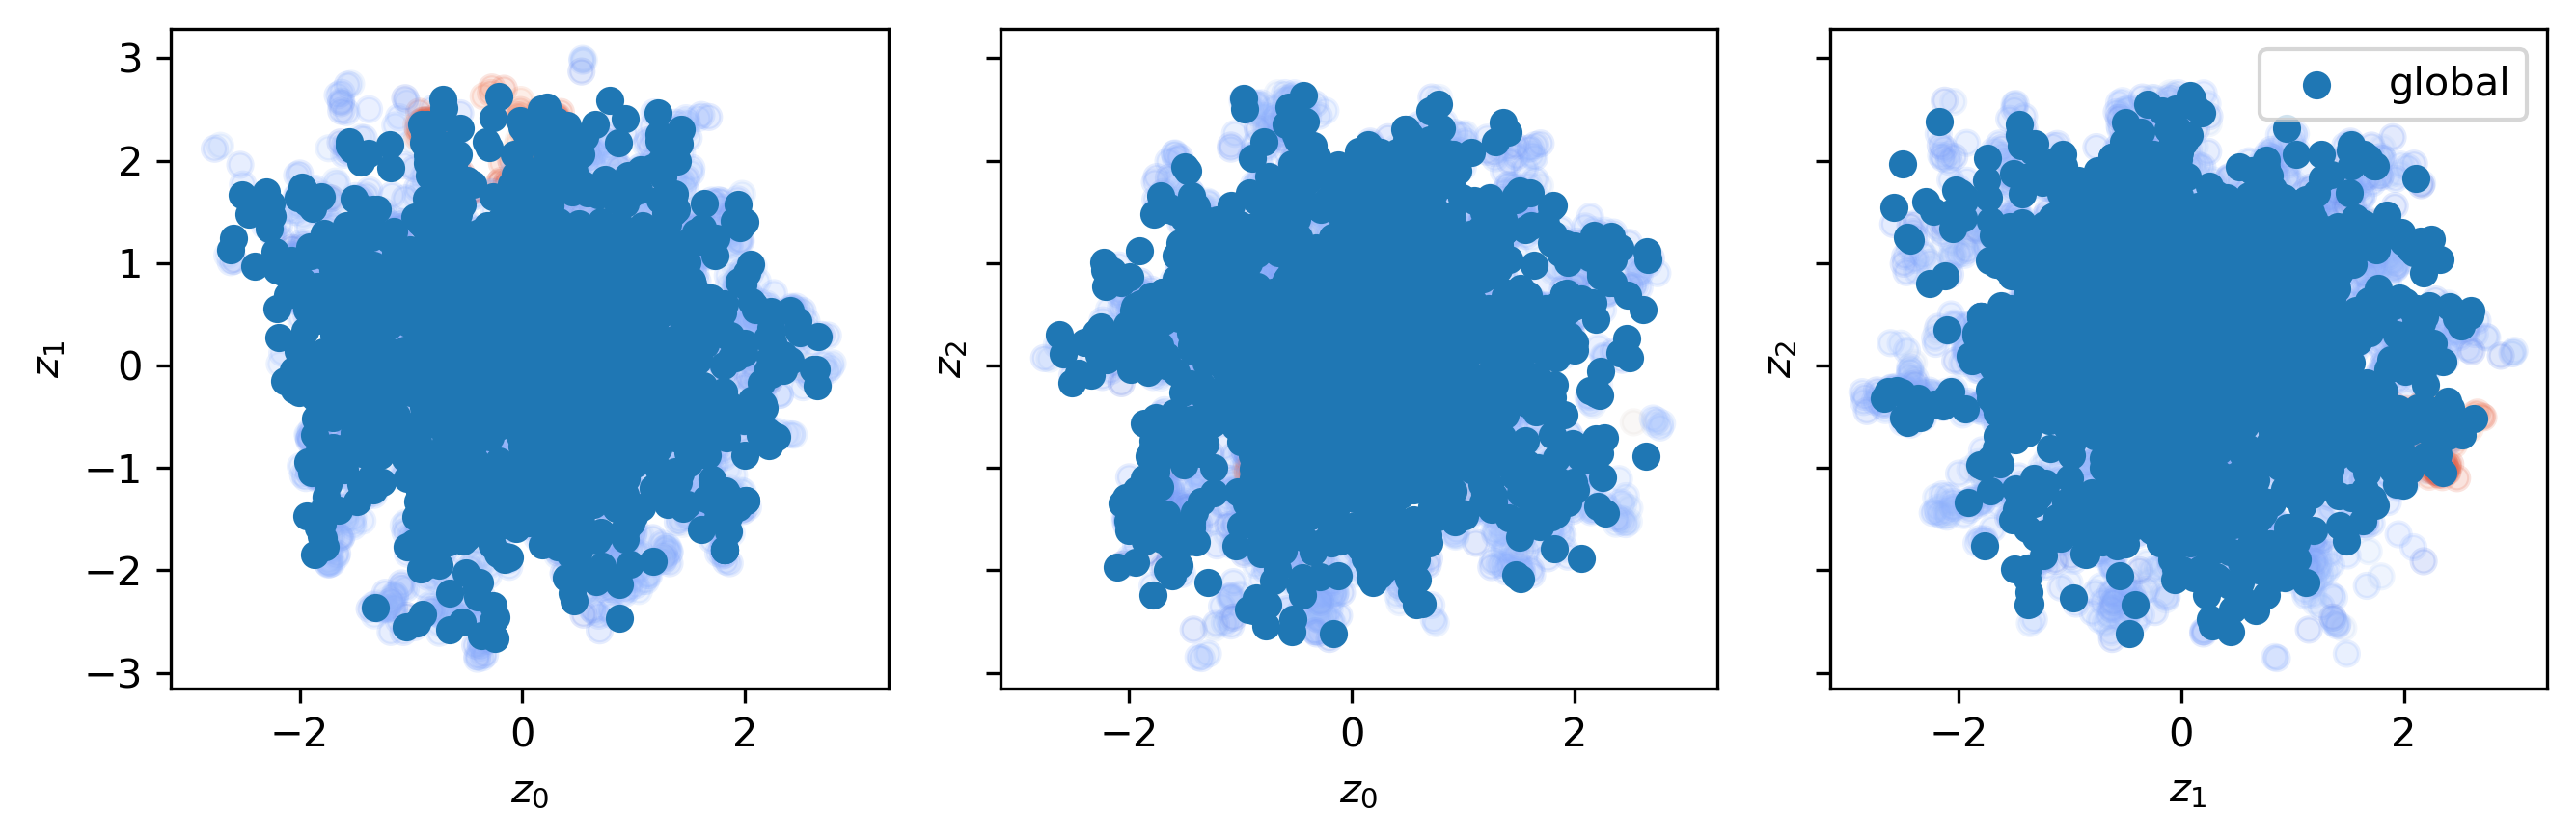

In [12]:
fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 300, sharex= True, sharey = True )
transparency = .2

axes[0].scatter(nat_z[:,0],nat_z[:,1],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)
axes[1].scatter(nat_z[:,0],nat_z[:,2],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)
axes[2].scatter(nat_z[:,1],nat_z[:,2],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)

axes[0].scatter(global_z_reembed[:,0], global_z_reembed[:,1])
axes[1].scatter(global_z_reembed[:,0], global_z_reembed[:,2])
axes[2].scatter(global_z_reembed[:,1], global_z_reembed[:,2], label = 'global')

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plt.tight_layout()
plt.legend()
plt.show()

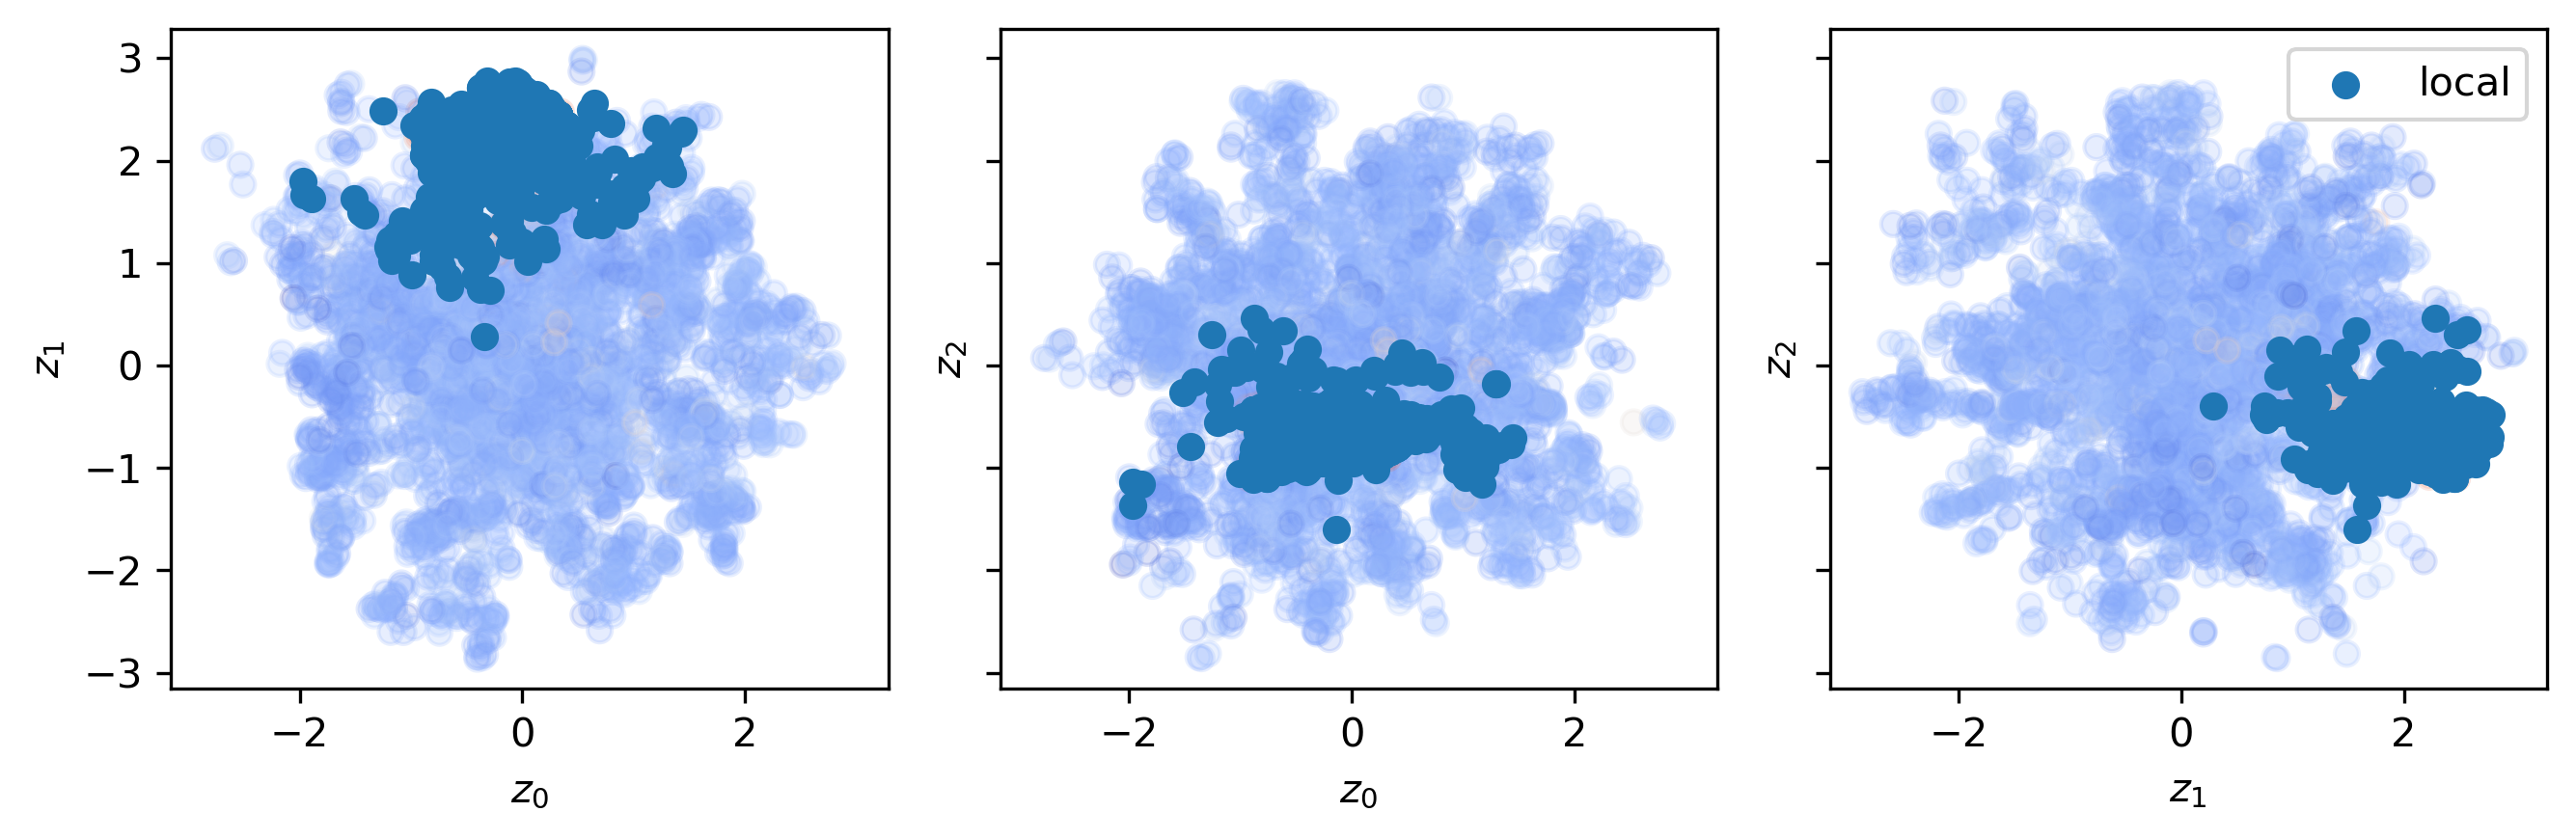

In [13]:
fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 300, sharex= True, sharey = True )
transparency = .2

axes[0].scatter(nat_z[:,0],nat_z[:,1],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)
axes[1].scatter(nat_z[:,0],nat_z[:,2],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)
axes[2].scatter(nat_z[:,1],nat_z[:,2],
                c = SH3_RE,cmap = 'coolwarm', 
                alpha = transparency)

axes[0].scatter(local_z_reembed[:,0], local_z_reembed[:,1])
axes[1].scatter(local_z_reembed[:,0], local_z_reembed[:,2])
axes[2].scatter(local_z_reembed[:,1], local_z_reembed[:,2], label = 'local')

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plt.tight_layout()
plt.legend()
plt.show()

## Conclusion

Results of PyTorch impletion of InfoVAE works the same as it is reported in 

https://www.biorxiv.org/content/10.1101/2022.12.21.521443v1 


Globally sampled sequences reproduced natural distribution.

Locally sampled sequences covers the region of natural functional sequences, and interpolated between the intches origin from evolution history (phylogeny).